In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9660 - acc: 0.3801
Epoch 00001: val_loss improved from inf to 1.55874, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_3_conv_checkpoint/001-1.5587.hdf5
36805/36805 [==============================] - 108s 3ms/sample - loss: 1.9659 - acc: 0.3801 - val_loss: 1.5587 - val_acc: 0.5304
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3597 - acc: 0.5824
Epoch 00002: val_loss improved from 1.55874 to 1.34426, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_3_conv_checkpoint/002-1.3443.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.3597 - acc: 0.5824 - val_loss: 1.3443 - val_acc: 0.5933
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1018 - acc: 0.6645
Epoch 00003: val_loss improved from 1.34426 to 1.3071

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9919
Epoch 00029: val_loss did not improve from 1.30712
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0397 - acc: 0.9919 - val_loss: 3.1319 - val_acc: 0.5707
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9921
Epoch 00030: val_loss did not improve from 1.30712
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0419 - acc: 0.9921 - val_loss: 3.1234 - val_acc: 0.5795
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9929
Epoch 00031: val_loss did not improve from 1.30712
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.0377 - acc: 0.9929 - val_loss: 3.0458 - val_acc: 0.5907
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9957
Epoch 00032: val_loss did not improve from 1.30712
36805/36805 [========

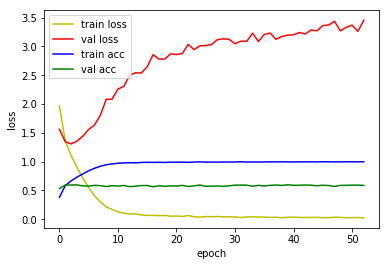

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3873 - acc: 0.5572
Loss: 1.387338678042094 Accuracy: 0.557217

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9013 - acc: 0.3915
Epoch 00001: val_loss improved from inf to 1.48261, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_4_conv_checkpoint/001-1.4826.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 1.9013 - acc: 0.3915 - val_loss: 1.4826 - val_acc: 0.5313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2744 - acc: 0.6087
Epoch 00002: val_loss improved from 1.48261 to 1.19296, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_4_conv_checkpoint/002-1.1930.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.2745 - acc: 0.6087 - val_loss: 1.1930 - val_acc: 0.6341
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9912
Epoch 00029: val_loss did not improve from 0.98438
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0363 - acc: 0.9912 - val_loss: 2.1728 - val_acc: 0.6830
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9904
Epoch 00030: val_loss did not improve from 0.98438
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0397 - acc: 0.9904 - val_loss: 1.9952 - val_acc: 0.6969
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9923
Epoch 00031: val_loss did not improve from 0.98438
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.0340 - acc: 0.9923 - val_loss: 2.1229 - val_acc: 0.6972
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9894
Epoch 00032: val_loss did not improve from 0.98438
36805/36805 [========

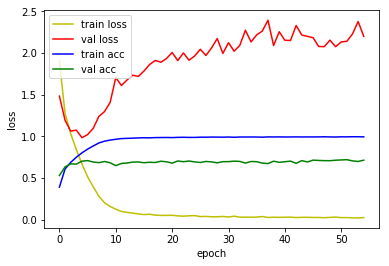

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.1082 - acc: 0.6685
Loss: 1.108153035212405 Accuracy: 0.6685358

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8650 - acc: 0.3976
Epoch 00001: val_loss improved from inf to 1.35969, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_5_conv_checkpoint/001-1.3597.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 1.8649 - acc: 0.3976 - val_loss: 1.3597 - val_acc: 0.5842
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2529 - acc: 0.6149
Epoch 00002: val_loss improved from 1.35969 to 1.10784, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_5_conv_checkpoint/002-1.1078.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.2528 - acc: 0.6149 - val_loss: 1.1078 - val_acc: 0.6604
Epoch 3/500
36800/36805 [============================>.] - ETA: 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9910
Epoch 00028: val_loss did not improve from 0.76229
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0387 - acc: 0.9910 - val_loss: 1.2330 - val_acc: 0.7873
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9905
Epoch 00029: val_loss did not improve from 0.76229
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0395 - acc: 0.9905 - val_loss: 1.3318 - val_acc: 0.7792
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9884
Epoch 00030: val_loss did not improve from 0.76229
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0441 - acc: 0.9884 - val_loss: 1.2662 - val_acc: 0.7824
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9902
Epoch 00031: val_loss did not improve from 0.76229
36805/36805 [========

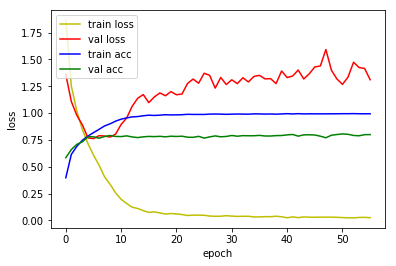

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.8661 - acc: 0.7551
Loss: 0.8660826236040545 Accuracy: 0.7551402

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9413 - acc: 0.3705
Epoch 00001: val_loss improved from inf to 1.36281, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_6_conv_checkpoint/001-1.3628.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 1.9412 - acc: 0.3705 - val_loss: 1.3628 - val_acc: 0.5556
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2832 - acc: 0.5974
Epoch 00002: val_loss improved from 1.36281 to 1.03428, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_6_conv_checkpoint/002-1.0343.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 1.2831 - acc: 0.5974 - val_loss: 1.0343 - val_acc: 0.6839
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9793
Epoch 00026: val_loss did not improve from 0.40141
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0658 - acc: 0.9793 - val_loss: 0.5147 - val_acc: 0.9015
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9795
Epoch 00027: val_loss did not improve from 0.40141
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0637 - acc: 0.9794 - val_loss: 0.5139 - val_acc: 0.8963
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9805
Epoch 00028: val_loss did not improve from 0.40141
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0612 - acc: 0.9805 - val_loss: 0.5352 - val_acc: 0.8998
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0535 - acc: 0.9827
Epoch 00029: val_loss did not improve from 0.40141
36805/36805 [========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9920
Epoch 00056: val_loss did not improve from 0.40141
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0269 - acc: 0.9920 - val_loss: 0.6366 - val_acc: 0.9043
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9897
Epoch 00057: val_loss did not improve from 0.40141
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0381 - acc: 0.9897 - val_loss: 0.6120 - val_acc: 0.9022
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.40141
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0230 - acc: 0.9936 - val_loss: 0.5792 - val_acc: 0.9071
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9952
Epoch 00059: val_loss did not improve from 0.40141
36805/36805 [========

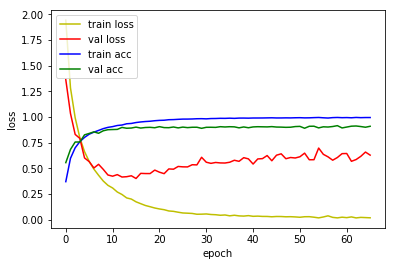

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4726 - acc: 0.8744
Loss: 0.4726447113825401 Accuracy: 0.87435097

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9718 - acc: 0.3533
Epoch 00001: val_loss improved from inf to 1.25795, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_7_conv_checkpoint/001-1.2580.hdf5
36805/36805 [==============================] - 123s 3ms/sample - loss: 1.9717 - acc: 0.3534 - val_loss: 1.2580 - val_acc: 0.6033
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1818 - acc: 0.6251
Epoch 00002: val_loss improved from 1.25795 to 0.94052, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_7_conv_checkpoint/002-0.9405.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.1817 - acc: 0.6251 - val_loss: 0.9405 - val_acc: 0.7058
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9741
Epoch 00025: val_loss did not improve from 0.19075
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0766 - acc: 0.9741 - val_loss: 0.2294 - val_acc: 0.9406
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9760
Epoch 00026: val_loss did not improve from 0.19075
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0743 - acc: 0.9760 - val_loss: 0.2417 - val_acc: 0.9448
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9777
Epoch 00027: val_loss did not improve from 0.19075
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0668 - acc: 0.9777 - val_loss: 0.2205 - val_acc: 0.9439
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0596 - acc: 0.9795
Epoch 00028: val_loss did not improve from 0.19075
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9929
Epoch 00054: val_loss did not improve from 0.19075
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0221 - acc: 0.9929 - val_loss: 0.2661 - val_acc: 0.9495
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9936
Epoch 00055: val_loss did not improve from 0.19075
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0197 - acc: 0.9936 - val_loss: 0.2805 - val_acc: 0.9453
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9931
Epoch 00056: val_loss did not improve from 0.19075
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0203 - acc: 0.9931 - val_loss: 0.2669 - val_acc: 0.9536
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9944
Epoch 00057: val_loss did not improve from 0.19075
36805/36805 [=====================

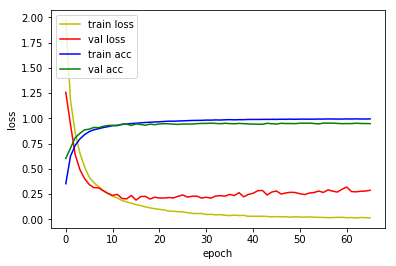

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2595 - acc: 0.9308
Loss: 0.2594976645949474 Accuracy: 0.93084115

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8009 - acc: 0.4111
Epoch 00001: val_loss improved from inf to 0.94695, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_8_conv_checkpoint/001-0.9469.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 1.8007 - acc: 0.4111 - val_loss: 0.9469 - val_acc: 0.6897
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9140 - acc: 0.7065
Epoch 00002: val_loss improved from 0.94695 to 0.69014, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_8_conv_checkpoint/002-0.6901.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.9141 - acc: 0.7065 - val_loss: 0.6901 - val_acc: 0.7731
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9815
Epoch 00026: val_loss did not improve from 0.14840
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0545 - acc: 0.9815 - val_loss: 0.1575 - val_acc: 0.9602
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9822
Epoch 00027: val_loss did not improve from 0.14840
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0526 - acc: 0.9822 - val_loss: 0.2006 - val_acc: 0.9534
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.9828
Epoch 00028: val_loss did not improve from 0.14840
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0524 - acc: 0.9828 - val_loss: 0.1829 - val_acc: 0.9553
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0502 - acc: 0.9832
Epoch 00029: val_loss did not improve from 0.14840
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9943
Epoch 00055: val_loss did not improve from 0.14622
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0185 - acc: 0.9943 - val_loss: 0.2137 - val_acc: 0.9611
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.14622
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0188 - acc: 0.9942 - val_loss: 0.1955 - val_acc: 0.9625
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0172 - acc: 0.9946
Epoch 00057: val_loss did not improve from 0.14622
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0172 - acc: 0.9946 - val_loss: 0.2029 - val_acc: 0.9641
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.14622
36805/36805 [=====================

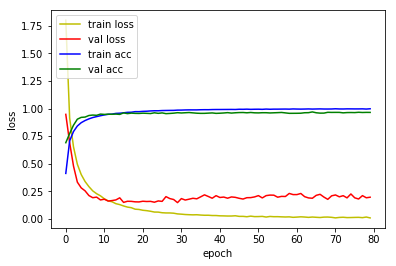

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2192 - acc: 0.9472
Loss: 0.219204667974834 Accuracy: 0.94724816

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5412 - acc: 0.4945
Epoch 00001: val_loss improved from inf to 0.69217, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_9_conv_checkpoint/001-0.6922.hdf5
36805/36805 [==============================] - 126s 3ms/sample - loss: 1.5412 - acc: 0.4945 - val_loss: 0.6922 - val_acc: 0.7687
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6894 - acc: 0.7733
Epoch 00002: val_loss improved from 0.69217 to 0.52031, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_025_DO_9_conv_checkpoint/002-0.5203.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 0.6894 - acc: 0.7733 - val_loss: 0.5203 - val_acc: 0.8269
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9902
Epoch 00027: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0303 - acc: 0.9902 - val_loss: 0.2037 - val_acc: 0.9576
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9910
Epoch 00028: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0272 - acc: 0.9910 - val_loss: 0.1696 - val_acc: 0.9627
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9912
Epoch 00029: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0279 - acc: 0.9913 - val_loss: 0.1539 - val_acc: 0.9658
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9926
Epoch 00030: val_loss did not improve from 0.15337
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9957
Epoch 00057: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0137 - acc: 0.9957 - val_loss: 0.1902 - val_acc: 0.9646
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9984
Epoch 00058: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0059 - acc: 0.9984 - val_loss: 0.2310 - val_acc: 0.9599
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9963
Epoch 00059: val_loss did not improve from 0.15337
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0115 - acc: 0.9963 - val_loss: 0.1963 - val_acc: 0.9630
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9969
Epoch 00060: val_loss did not improve from 0.15337
36805/36805 [========

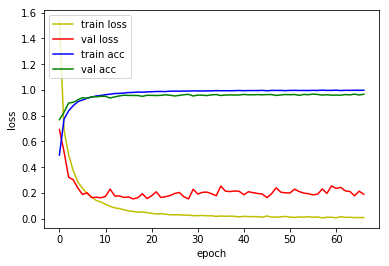

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2185 - acc: 0.9418
Loss: 0.2185425144365891 Accuracy: 0.9418484



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_025_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)

#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_025_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_44 (Activation)   (N

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4726 - acc: 0.8744
Loss: 0.4726447113825401 Accuracy: 0.87435097

1D_CNN_custom_ch_128_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_62 (Conv1D)           

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2185 - acc: 0.9418
Loss: 0.2185425144365891 Accuracy: 0.9418484


In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_128_DO_025_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_44 (Activation)   (N

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.7264 - acc: 0.8906
Loss: 0.7263879891991739 Accuracy: 0.8905504

1D_CNN_custom_ch_128_DO_025_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2615 - acc: 0.9535
Loss: 0.2615429059900725 Accuracy: 0.9534787
